# MobileNet Two-Stage Training Pipeline

Implementation of the two-stage MobileNet training pipeline with mandatory YOLO preprocessing as specified in MobileNet_training.md.

## Pipeline Overview:
1. **Stage 1**: Train MobileNet on OAT dataset (18 classes) with YOLO preprocessing
2. **Stage 2**: Fine-tune on Real dataset (13 classes) with architecture adaptation

## Key Features:
- Mandatory YOLO preprocessing for footprint detection and cropping
- Proper architecture adaptation between stages (18→13 classes)
- Backbone weight transfer with classification head rebuilding
- Comprehensive evaluation and visualization

## Setup and Imports

In [1]:
import tensorflow as tf
import keras
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
from keras import Input
from keras.src.utils import image_dataset_from_directory
from sklearn.metrics import confusion_matrix, classification_report
from sklearn.model_selection import train_test_split
import os
import sys
from pathlib import Path
from PIL import Image



# Add project root to path for imports
project_root = Path().resolve().parent.parent
sys.path.append(str(project_root))


2025-07-03 14:27:43.242532: I tensorflow/core/util/port.cc:153] oneDNN custom operations are on. You may see slightly different numerical results due to floating-point round-off errors from different computation orders. To turn them off, set the environment variable `TF_ENABLE_ONEDNN_OPTS=0`.
2025-07-03 14:27:43.255267: E external/local_xla/xla/stream_executor/cuda/cuda_fft.cc:477] Unable to register cuFFT factory: Attempting to register factory for plugin cuFFT when one has already been registered
E0000 00:00:1751545663.269442 2475562 cuda_dnn.cc:8310] Unable to register cuDNN factory: Attempting to register factory for plugin cuDNN when one has already been registered
E0000 00:00:1751545663.273839 2475562 cuda_blas.cc:1418] Unable to register cuBLAS factory: Attempting to register factory for plugin cuBLAS when one has already been registered
2025-07-03 14:27:43.292558: I tensorflow/core/platform/cpu_feature_guard.cc:210] This TensorFlow binary is optimized to use available CPU instr

## GPU Configuration

In [2]:
# Configure GPU
gpus = tf.config.experimental.list_physical_devices("GPU")
if gpus:
    try:
        for gpu in gpus:
            tf.config.experimental.set_memory_growth(gpu, True)
        print(f"GPU detected: {len(gpus)} device(s)")
    except RuntimeError as e:
        print(f"GPU configuration error: {e}")
else:
    print("No GPU detected, using CPU")

print(f"TensorFlow version: {tf.__version__}")
print(f"Keras version: {keras.__version__}")

GPU detected: 1 device(s)
TensorFlow version: 2.18.0
Keras version: 3.7.0


## YOLO Preprocessing Setup

In [3]:
# Initialize YOLO inference for preprocessing
from scripts.yolo_finetuning.yolo_inference_onnx import YOLOONNXInference

yolo_model_path = "../yolo/best_so_far.onnx"
yolo_inference = YOLOONNXInference(
    model_path=yolo_model_path,
    conf_threshold=0.1,
)
print("YOLO inference initialized for preprocessing")

YOLO inference initialized for preprocessing


## Data Preprocessing Functions

In [4]:
def preprocess_image_with_yolo(image_path, target_size=(224, 224)):
    try:
        # Convert tensor to string if needed
        if isinstance(image_path, tf.Tensor):
            image_path = image_path.numpy().decode('utf-8')
        elif isinstance(image_path, bytes):
            image_path = image_path.decode('utf-8')
        
        # Get YOLO crop - this returns a tuple (bbox, cropped_image)
        res = yolo_inference.infer_and_get_best_crop(str(image_path))
        # get the cropped image (numpy array) if available, else use the original image
        bbox, cropped_img = res if res is not None else None

        image = Image.fromarray(cropped_img) if res is not None else Image.open(image_path)


        image = image.resize(target_size)

        if image.mode != 'RGB':
                image = image.convert('RGB')

        image_array = np.array(image, dtype=np.float32)

        return image_array
    
    except Exception as e:
        print(f"Error processing {image_path}: {e}")
        # Return a black image as fallback
        return np.zeros((*target_size, 3), dtype=np.float32)

def preprocess_image_simple(image_path, target_size=(224, 224)):
    """Simple preprocessing without YOLO - just center crop and resize"""
    try:
        # Convert tensor to string if needed
        if isinstance(image_path, tf.Tensor):
            image_path = image_path.numpy().decode('utf-8')
        elif isinstance(image_path, bytes):
            image_path = image_path.decode('utf-8')

        # Load image
        image = Image.open(image_path)

        # Center crop to square
        min_dim = min(image.size)
        left = (image.size[0] - min_dim) // 2
        top = (image.size[1] - min_dim) // 2
        image = image.crop((left, top, left + min_dim, top + min_dim))

        # Resize to target size
        image = image.resize(target_size)

        # Convert to RGB if needed
        if image.mode != 'RGB':
            image = image.convert('RGB')

        # Convert to numpy array and normalize
        image_array = np.array(image, dtype=np.float32)
        image_array = image_array / 255.0

        return image_array

    except Exception as e:
        print(f"Error processing {image_path}: {e}")
        # Return a black image as fallback
        return np.zeros((*target_size, 3), dtype=np.float32)

def create_yolo_preprocessed_dataset(data_dir, class_names, batch_size=16, shuffle=True):
    def load_and_preprocess_image(path, label):
        image = tf.py_function(
            func=preprocess_image_with_yolo,
            inp=[path],
            Tout=tf.float32
        )
        image.set_shape([224, 224, 3])
        return image, label
    
    # Get all image paths and labels
    image_paths = []
    labels = []
    
    for class_idx, class_name in enumerate(class_names):
        class_dir = os.path.join(data_dir, class_name)
        if os.path.exists(class_dir):
            for img_file in os.listdir(class_dir):
                if img_file.lower().endswith(('.png', '.jpg', '.jpeg')):
                    image_paths.append(os.path.join(class_dir, img_file))
                    labels.append(class_idx)
    
    print(f"Found {len(image_paths)} images across {len(class_names)} classes")
    
    # Create dataset
    dataset = tf.data.Dataset.from_tensor_slices((image_paths, labels))
    
    if shuffle:
        dataset = dataset.shuffle(len(image_paths))
    
    dataset = dataset.map(load_and_preprocess_image, num_parallel_calls=tf.data.AUTOTUNE)
    dataset = dataset.batch(batch_size)
    dataset = dataset.prefetch(tf.data.AUTOTUNE)
    
    return dataset

def create_stratified_split_dataset(data_dir, class_names, batch_size=16, train_split=0.8, seed=42, use_yolo_preprocessing=True):
    # Choose preprocessing function based on flag
    if use_yolo_preprocessing:
        preprocess_func = preprocess_image_with_yolo
        print("Using YOLO preprocessing")
    else:
        preprocess_func = preprocess_image_simple
        print("Using simple preprocessing (no YOLO)")
    
    def load_and_preprocess_image(path, label):
        image = tf.py_function(
            func=preprocess_func,
            inp=[path],
            Tout=tf.float32
        )
        image.set_shape([224, 224, 3])
        return image, label
    
    # Debug: Check data directory
    print(f"Loading data from: {os.path.abspath(data_dir)}")
    print(f"Directory exists: {os.path.exists(data_dir)}")
    
    # Get all image paths and labels
    image_paths = []
    labels = []
    
    for class_idx, class_name in enumerate(class_names):
        class_dir = os.path.join(data_dir, class_name)
        
        if os.path.exists(class_dir):
            class_images = []
            for img_file in os.listdir(class_dir):
                if img_file.lower().endswith(('.png', '.jpg', '.jpeg')):
                    class_images.append(os.path.join(class_dir, img_file))
            
            print(f"Class {class_name} (idx {class_idx}): {len(class_images)} images")
            
            if len(class_images) == 0:
                print(f"WARNING: No images found for class {class_name}!")
                continue
                
            image_paths.extend(class_images)
            labels.extend([class_idx] * len(class_images))
        else:
            print(f"ERROR: Directory not found for class {class_name}: {class_dir}")
    
    print(f"Total: {len(image_paths)} images across {len(class_names)} classes")
    
    if len(image_paths) == 0:
        raise ValueError("No images found! Check the data directory path.")
    
    # Check for empty classes
    unique_labels = set(labels)
    if len(unique_labels) != len(class_names):
        missing_classes = set(range(len(class_names))) - unique_labels
        print(f"WARNING: Missing classes: {[class_names[i] for i in missing_classes]}")
    
    # Stratified split at image level
    try:
        train_paths, val_paths, train_labels, val_labels = train_test_split(
            image_paths, labels, 
            test_size=1-train_split, 
            stratify=labels, 
            random_state=seed
        )
    except ValueError as e:
        print(f"Stratified split failed: {e}")
        print("Label distribution:")
        import numpy as np
        label_counts = np.bincount(labels, minlength=len(class_names))
        for i, (class_name, count) in enumerate(zip(class_names, label_counts)):
            print(f"  {class_name}: {count} images")
        raise
    
    print(f"Train: {len(train_paths)} images, Val: {len(val_paths)} images")
    
    # Print class distribution
    import numpy as np
    train_class_counts = np.bincount(train_labels, minlength=len(class_names))
    val_class_counts = np.bincount(val_labels, minlength=len(class_names))
    
    print("\nClass distribution:")
    for i, class_name in enumerate(class_names):
        print(f"  {class_name}: Train={train_class_counts[i]}, Val={val_class_counts[i]}")
    
    # Create datasets
    train_ds = tf.data.Dataset.from_tensor_slices((train_paths, train_labels))
    train_ds = train_ds.shuffle(len(train_paths), seed=seed)
    train_ds = train_ds.map(load_and_preprocess_image, num_parallel_calls=tf.data.AUTOTUNE)
    train_ds = train_ds.batch(batch_size)
    train_ds = train_ds.prefetch(tf.data.AUTOTUNE)
    
    val_ds = tf.data.Dataset.from_tensor_slices((val_paths, val_labels))
    val_ds = val_ds.map(load_and_preprocess_image, num_parallel_calls=tf.data.AUTOTUNE)
    val_ds = val_ds.batch(batch_size)
    val_ds = val_ds.prefetch(tf.data.AUTOTUNE)
    
    return train_ds, val_ds

## Stage 1: OAT Dataset Training (18 classes)

In [5]:
# OAT dataset paths
oat_base_path = "../../data/OpenAnimalTracks/cropped_imgs"
oat_train_path = os.path.join(oat_base_path, "train")
oat_val_path = os.path.join(oat_base_path, "val")
oat_test_path = os.path.join(oat_base_path, "test")

oat_class_names = sorted([d for d in os.listdir(oat_train_path)
                         if os.path.isdir(os.path.join(oat_train_path, d))])
print(f"OAT classes ({len(oat_class_names)}): {oat_class_names}")

OAT classes (18): ['beaver', 'black_bear', 'bob_cat', 'coyote', 'elephant', 'goose', 'gray_fox', 'horse', 'lion', 'mink', 'mouse', 'muledeer', 'otter', 'raccoon', 'rat', 'skunk', 'turkey', 'western_grey_squirrel']


In [6]:
# Create OAT datasets with YOLO preprocessing
print("Creating OAT training dataset with YOLO preprocessing")
oat_train_ds = image_dataset_from_directory(
    oat_train_path,
    image_size=(224, 224),
    batch_size=16,
    shuffle=True,
)

print("Creating OAT validation dataset with YOLO preprocessing")
oat_val_ds = image_dataset_from_directory(
    oat_val_path,
    image_size=(224, 224),
    batch_size=16,
    shuffle=True,
)

print("Creating OAT test dataset with YOLO preprocessing")
oat_test_ds = image_dataset_from_directory(
    oat_test_path,
    image_size=(224, 224),
    batch_size=16,
    shuffle=True,
)

Creating OAT training dataset with YOLO preprocessing
Found 2514 files belonging to 18 classes.


I0000 00:00:1751545671.091765 2475562 gpu_device.cc:2022] Created device /job:localhost/replica:0/task:0/device:GPU:0 with 20945 MB memory:  -> device: 0, name: NVIDIA GeForce RTX 4090, pci bus id: 0000:01:00.0, compute capability: 8.9


Creating OAT validation dataset with YOLO preprocessing
Found 346 files belonging to 18 classes.
Creating OAT test dataset with YOLO preprocessing
Found 719 files belonging to 18 classes.


In [7]:
# Data augmentation for Stage 1
data_augmentation = keras.Sequential([
  keras.layers.Input(shape=(224, 224, 3)),
  keras.layers.RandomFlip("horizontal"),
  keras.layers.RandomRotation(0.1),
  keras.layers.RandomZoom(0.1),
  keras.layers.RandomContrast(0.1),
])
# Create MobileNet base model
mobilenet_base = keras.applications.MobileNetV3Small(
    input_shape=(224, 224, 3),
    include_top=False,
    weights="imagenet"
)

# Freeze base model for Stage 1
mobilenet_base.trainable = False

# Build Stage 1 model (18 classes)
stage1_model = keras.Sequential([
    data_augmentation,
    mobilenet_base,
    keras.layers.GlobalAveragePooling2D(),
    keras.layers.Dense(512, activation="relu", kernel_regularizer=keras.regularizers.l2(0.01)),
    keras.layers.Dropout(0.3),
    keras.layers.BatchNormalization(),
    keras.layers.Dense(256, activation="relu", kernel_regularizer=keras.regularizers.l2(0.01)),
    keras.layers.Dropout(0.3),
    keras.layers.Dense(18, activation="softmax", name="oat_classifier")
], name="stage1_oat_model")

print("Stage 1 model architecture:")
stage1_model.summary()

Stage 1 model architecture:


Model: "stage1_oat_model"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━┓
┃ Layer (type)                    ┃ Output Shape           ┃       Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━┩
│ sequential (Sequential)         │ (None, 224, 224, 3)    │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ MobileNetV3Small (Functional)   │ (None, 7, 7, 576)      │       939,120 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ global_average_pooling2d        │ (None, 576)            │             0 │
│ (GlobalAveragePooling2D)        │                        │               │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense (Dense)                   │ (None, 512)            │       295,424 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dropout (Dropout)               │ (None, 512)            │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ batch_normalization             │ (None, 512)            │         2,048 │
│ (BatchNormalization)            │                        │               │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_1 (Dense)                 │ (None, 256)            │       131,328 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dropout_1 (Dropout)             │ (None, 256)            │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ oat_classifier (Dense)          │ (None, 18)             │         4,626 │
└─────────────────────────────────┴────────────────────────┴───────────────┘

 Total params: 1,372,546 (5.24 MB)

 Trainable params: 432,402 (1.65 MB)

 Non-trainable params: 940,144 (3.59 MB)

In [8]:
# Compile Stage 1 model
stage1_model.compile(
    optimizer="adamax",
    loss="sparse_categorical_crossentropy",
    metrics=["accuracy"]
)

# Define callbacks for Stage 1
stage1_callbacks = [
    keras.callbacks.EarlyStopping(
        monitor="val_loss",
        patience=3,
        restore_best_weights=True,
        verbose=1
    ),
    keras.callbacks.ReduceLROnPlateau(
        monitor="val_loss",
        factor=0.5,
        patience=2,
        min_lr=1e-7,
        verbose=1
    )
]

In [9]:
# Train Stage 1 model
print("Starting Stage 1 training on OAT dataset...")
stage1_history = stage1_model.fit(
    oat_train_ds,
    epochs=50,
    validation_data=oat_val_ds,
    callbacks=stage1_callbacks,
    verbose=1
)

# Save Stage 1 model
stage1_model.save("mobilenet_oat_stage1.keras")
print("Stage 1 model saved as 'mobilenet_oat_stage1.keras'")

Starting Stage 1 training on OAT dataset...
Epoch 1/50


I0000 00:00:1751545677.995001 2475891 cuda_dnn.cc:529] Loaded cuDNN version 90300


158/158 ━━━━━━━━━━━━━━━━━━━━ 7s 14ms/step - accuracy: 0.1267 - loss: 10.8873 - val_accuracy: 0.3035 - val_loss: 9.0267 - learning_rate: 0.0010
Epoch 2/50
158/158 ━━━━━━━━━━━━━━━━━━━━ 1s 8ms/step - accuracy: 0.3001 - loss: 8.7896 - val_accuracy: 0.3642 - val_loss: 7.9691 - learning_rate: 0.0010
Epoch 3/50
158/158 ━━━━━━━━━━━━━━━━━━━━ 1s 8ms/step - accuracy: 0.3430 - loss: 7.8356 - val_accuracy: 0.3988 - val_loss: 7.2388 - learning_rate: 0.0010
Epoch 4/50
158/158 ━━━━━━━━━━━━━━━━━━━━ 1s 8ms/step - accuracy: 0.3850 - loss: 7.0794 - val_accuracy: 0.4133 - val_loss: 6.6251 - learning_rate: 0.0010
Epoch 5/50
158/158 ━━━━━━━━━━━━━━━━━━━━ 1s 7ms/step - accuracy: 0.4399 - loss: 6.4203 - val_accuracy: 0.4335 - val_loss: 6.1290 - learning_rate: 0.0010
Epoch 6/50
158/158 ━━━━━━━━━━━━━━━━━━━━ 1s 8ms/step - accuracy: 0.4419 - loss: 5.8789 - val_accuracy: 0.4133 - val_loss: 5.7495 - learning_rate: 0.0010
Epoch 7/50
158/158 ━━━━━━━━━━━━━━━━━━━━ 1s 8ms/step - accuracy: 0.4606 - loss: 5.5024 - val_accur

In [10]:
# Evaluate Stage 1 model
stage1_test_loss, stage1_test_accuracy = stage1_model.evaluate(oat_test_ds, verbose=1)
print(f"Stage 1 Test Accuracy: {stage1_test_accuracy:.4f}")
print(f"Stage 1 Test Loss: {stage1_test_loss:.4f}")

45/45 ━━━━━━━━━━━━━━━━━━━━ 0s 6ms/step - accuracy: 0.4972 - loss: 2.4902
Stage 1 Test Accuracy: 0.5146
Stage 1 Test Loss: 2.4543


In [11]:
# Load Stage 1 model and extract backbone weights
stage1_loaded = keras.models.load_model("mobilenet_oat_stage1.keras")

# Get the MobileNet backbone from Stage 1 model
stage1_loaded.trainable = True

# Unfreeze last N layers for fine-tuning
fine_tune_at = len(stage1_loaded.layers) - 20

for layer in stage1_loaded.layers[:fine_tune_at]:
    layer.trainable = False

print(f"Unfroze last {len(stage1_loaded.layers) - fine_tune_at} layers for fine-tuning")
stage1_loaded.compile(
    optimizer=keras.optimizers.Adam(learning_rate=1e-5),
    loss="sparse_categorical_crossentropy",
    metrics=["accuracy"]
)

stage1_loaded.summary()

Unfroze last 20 layers for fine-tuning


Model: "stage1_oat_model"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━┓
┃ Layer (type)                    ┃ Output Shape           ┃       Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━┩
│ sequential (Sequential)         │ (None, 224, 224, 3)    │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ MobileNetV3Small (Functional)   │ (None, 7, 7, 576)      │       939,120 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ global_average_pooling2d        │ (None, 576)            │             0 │
│ (GlobalAveragePooling2D)        │                        │               │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense (Dense)                   │ (None, 512)            │       295,424 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dropout (Dropout)               │ (None, 512)            │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ batch_normalization             │ (None, 512)            │         2,048 │
│ (BatchNormalization)            │                        │               │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_1 (Dense)                 │ (None, 256)            │       131,328 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dropout_1 (Dropout)             │ (None, 256)            │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ oat_classifier (Dense)          │ (None, 18)             │         4,626 │
└─────────────────────────────────┴────────────────────────┴───────────────┘

 Total params: 1,372,546 (5.24 MB)

 Trainable params: 432,402 (1.65 MB)

 Non-trainable params: 940,144 (3.59 MB)

In [12]:
# Fine tune stage 1 model
stage1_loaded.fit(
    oat_train_ds,
    epochs=10,
    validation_data=oat_val_ds,
    callbacks=[keras.callbacks.EarlyStopping(monitor="val_loss", patience=3)]
)

stage1_loaded.save("mobilenet_oat_stage1_fine_tuned.keras")

Epoch 1/10
158/158 ━━━━━━━━━━━━━━━━━━━━ 5s 12ms/step - accuracy: 0.7689 - loss: 1.5276 - val_accuracy: 0.4913 - val_loss: 2.5465
Epoch 2/10
158/158 ━━━━━━━━━━━━━━━━━━━━ 1s 7ms/step - accuracy: 0.7851 - loss: 1.5131 - val_accuracy: 0.4942 - val_loss: 2.5447
Epoch 3/10
158/158 ━━━━━━━━━━━━━━━━━━━━ 1s 7ms/step - accuracy: 0.7732 - loss: 1.5079 - val_accuracy: 0.4942 - val_loss: 2.5629
Epoch 4/10
158/158 ━━━━━━━━━━━━━━━━━━━━ 1s 7ms/step - accuracy: 0.7697 - loss: 1.5235 - val_accuracy: 0.4971 - val_loss: 2.5578
Epoch 5/10
158/158 ━━━━━━━━━━━━━━━━━━━━ 1s 8ms/step - accuracy: 0.7901 - loss: 1.5009 - val_accuracy: 0.5000 - val_loss: 2.5607


## Stage 2: Real Dataset Fine-tuning (13 classes)

In [13]:
# Real dataset paths
real_base_path = "../../data/dataset_no_oat_downsample"

# Get Real dataset class names (13 classes)
real_class_names = sorted([d for d in os.listdir(real_base_path) 
                          if os.path.isdir(os.path.join(real_base_path, d))])
print(f"Real dataset classes ({len(real_class_names)}): {real_class_names}")

import os
print(f"Dataset path exists: {os.path.exists(real_base_path)}")
print(f"Dataset path resolved: {os.path.abspath(real_base_path)}")

# Count images per class
for class_name in real_class_names:
    class_path = os.path.join(real_base_path, class_name)
    if os.path.exists(class_path):
        image_files = [f for f in os.listdir(class_path) 
                      if f.lower().endswith(('.png', '.jpg', '.jpeg'))]
        print(f"  {class_name}: {len(image_files)} images")
    else:
        print(f"  {class_name}: PATH NOT FOUND")

Real dataset classes (13): ['castor', 'chat', 'chien', 'coyotte', 'ecureuil', 'lapin', 'loup', 'lynx', 'ours', 'puma', 'rat', 'raton_laveur', 'renard']
Dataset path exists: True
Dataset path resolved: /home/hugo/PycharmProjects/Wildlens_Model/data/dataset_no_oat_downsample
  castor: 85 images
  chat: 85 images
  chien: 85 images
  coyotte: 85 images
  ecureuil: 85 images
  lapin: 85 images
  loup: 85 images
  lynx: 85 images
  ours: 85 images
  puma: 85 images
  rat: 85 images
  raton_laveur: 85 images
  renard: 85 images


In [28]:
# Create Real dataset with stratified split
print("Creating Real dataset with stratified split")

# Use the corrected dataset path
real_base_path = "../../data/dataset_no_oat_downsample"

real_train_ds, real_val_ds = create_stratified_split_dataset(
    real_base_path, 
    real_class_names, 
    batch_size=32, 
    train_split=0.8, 
    seed=42,
    use_yolo_preprocessing=False
)

Creating Real dataset with stratified split
Using simple preprocessing (no YOLO)
Loading data from: /home/hugo/PycharmProjects/Wildlens_Model/data/dataset_no_oat_downsample
Directory exists: True
Class castor (idx 0): 85 images
Class chat (idx 1): 85 images
Class chien (idx 2): 85 images
Class coyotte (idx 3): 85 images
Class ecureuil (idx 4): 85 images
Class lapin (idx 5): 85 images
Class loup (idx 6): 85 images
Class lynx (idx 7): 85 images
Class ours (idx 8): 85 images
Class puma (idx 9): 85 images
Class rat (idx 10): 85 images
Class raton_laveur (idx 11): 85 images
Class renard (idx 12): 85 images
Total: 1105 images across 13 classes
Train: 884 images, Val: 221 images

Class distribution:
  castor: Train=68, Val=17
  chat: Train=68, Val=17
  chien: Train=68, Val=17
  coyotte: Train=68, Val=17
  ecureuil: Train=68, Val=17
  lapin: Train=68, Val=17
  loup: Train=68, Val=17
  lynx: Train=68, Val=17
  ours: Train=68, Val=17
  puma: Train=68, Val=17
  rat: Train=68, Val=17
  raton_laveu

In [29]:
# Debug: Inspect actual batch content to verify data integrity
print("BATCH INSPECTION - Checking data content")

# Take a few batches and inspect their content
for batch_idx, (batch_images, batch_labels) in enumerate(real_train_ds.take(3)):
    print(f"\nBatch {batch_idx + 1}:")
    print(f"  Shape: {batch_images.shape}")
    print(f"  Labels: {batch_labels.numpy()}")
    
    # Check class distribution in this batch
    unique_labels, counts = np.unique(batch_labels.numpy(), return_counts=True)
    print(f"  Classes in batch: {dict(zip(unique_labels, counts))}")
    
    # Check if images are actually different (not all black/identical)
    batch_mean = np.mean(batch_images.numpy())
    batch_std = np.std(batch_images.numpy())
    print(f"  Image stats - Mean: {batch_mean:.4f}, Std: {batch_std:.4f}")
    
    # Check individual image means to see if they're all the same
    individual_means = np.mean(batch_images.numpy(), axis=(1,2,3))
    print(f"  Individual image means (first 5): {individual_means[:5]}")
    
    if batch_std < 0.01:
        print("WARNING: Very low std deviation - images might be identical/corrupted!")
    
    if len(unique_labels) == 1:
        print(f"WARNING: Batch contains only one class: {real_class_names[unique_labels[0]]}")
    else:
        print(f"Good: Batch contains {len(unique_labels)} different classes")


BATCH INSPECTION - Checking data content

Batch 1:
  Shape: (32, 224, 224, 3)
  Labels: [ 5  3  8  8  5  2  4 11  6  0  6  7  1  7  4 10  8  4 11  6  0  0  3 11
 12  7  8  2  2 10  1 12]
  Classes in batch: {np.int32(0): np.int64(3), np.int32(1): np.int64(2), np.int32(2): np.int64(3), np.int32(3): np.int64(2), np.int32(4): np.int64(3), np.int32(5): np.int64(2), np.int32(6): np.int64(3), np.int32(7): np.int64(3), np.int32(8): np.int64(4), np.int32(10): np.int64(2), np.int32(11): np.int64(3), np.int32(12): np.int64(2)}
  Image stats - Mean: 0.5705, Std: 0.1649
  Individual image means (first 5): [0.6390568  0.50817615 0.39927503 0.5108697  0.6341239 ]
Good: Batch contains 12 different classes

Batch 2:
  Shape: (32, 224, 224, 3)
  Labels: [ 4  5 11  3 10 10  8 11  0 12  8  1  7  0  9 11 11  8  9 10  0 12  9  5
  5 12  5  7  4  5 10 12]
  Classes in batch: {np.int32(0): np.int64(3), np.int32(1): np.int64(1), np.int32(3): np.int64(1), np.int32(4): np.int64(2), np.int32(5): np.int64(5), np.

In [30]:
# Load Stage 1 model and extract backbone weights
stage1_finetuned = keras.models.load_model("mobilenet_oat_stage1_fine_tuned.keras")

print(stage1_finetuned.layers)

# Get the MobileNet backbone from Stage 1 model
# Skip data augmentation layer (index 0) and get MobileNet (index 1)
stage1_mobilenet = stage1_finetuned.layers[1]

print(stage1_mobilenet)

[<Sequential name=sequential, built=True>, <Functional name=MobileNetV3Small, built=True>, <GlobalAveragePooling2D name=global_average_pooling2d, built=True>, <Dense name=dense, built=True>, <Dropout name=dropout, built=True>, <BatchNormalization name=batch_normalization, built=True>, <Dense name=dense_1, built=True>, <Dropout name=dropout_1, built=True>, <Dense name=oat_classifier, built=True>]
<Functional name=MobileNetV3Small, built=True>


In [31]:
# Build Stage 2 model (13 classes) with new classification head

# Unfreeze last N layers for fine-tuning
fine_tune_at = len(stage1_mobilenet.layers) - 20
stage1_mobilenet.trainable = True

for layer in stage1_mobilenet.layers[:fine_tune_at]:
    layer.trainable = False

print(f"Unfroze last {len(stage1_mobilenet.layers) - fine_tune_at} layers for fine-tuning")

# Stage 2 model with reduced regularization
stage2_model = keras.Sequential([
    data_augmentation,
    stage1_mobilenet,
    keras.layers.GlobalAveragePooling2D(),
    keras.layers.Dense(512, activation="relu", kernel_regularizer=keras.regularizers.l2(0.001)),
    keras.layers.Dropout(0.2),
    keras.layers.BatchNormalization(),
    keras.layers.Dense(256, activation="relu", kernel_regularizer=keras.regularizers.l2(0.001)),
    keras.layers.Dropout(0.2),
    keras.layers.Dense(13, activation="softmax", name="real_classifier")
], name="stage2_real_model")

print("Stage 2 model architecture:")
stage2_model.summary()

Unfroze last 20 layers for fine-tuning
Stage 2 model architecture:


Model: "stage2_real_model"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━┓
┃ Layer (type)                    ┃ Output Shape           ┃       Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━┩
│ sequential (Sequential)         │ (None, 224, 224, 3)    │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ MobileNetV3Small (Functional)   │ (None, 7, 7, 576)      │       939,120 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ global_average_pooling2d_2      │ (None, 576)            │             0 │
│ (GlobalAveragePooling2D)        │                        │               │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_4 (Dense)                 │ (None, 512)            │       295,424 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dropout_4 (Dropout)             │ (None, 512)            │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ batch_normalization_2           │ (None, 512)            │         2,048 │
│ (BatchNormalization)            │                        │               │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_5 (Dense)                 │ (None, 256)            │       131,328 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dropout_5 (Dropout)             │ (None, 256)            │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ real_classifier (Dense)         │ (None, 13)             │         3,341 │
└─────────────────────────────────┴────────────────────────┴───────────────┘

 Total params: 1,371,261 (5.23 MB)

 Trainable params: 781,853 (2.98 MB)

 Non-trainable params: 589,408 (2.25 MB)

In [32]:
# Compile Stage 2 model with improved learning rate
stage2_model.compile(
    optimizer=keras.optimizers.Adam(learning_rate=1e-3),
    loss="sparse_categorical_crossentropy",
    metrics=["accuracy"]
)

# Custom callback to monitor per-class accuracy
class PerClassAccuracyCallback(keras.callbacks.Callback):
    def __init__(self, validation_data, class_names):
        super().__init__()
        self.validation_data = validation_data
        self.class_names = class_names
    
    def on_epoch_end(self, epoch, logs=None):
        if epoch % 5 == 0:
            y_true = []
            y_pred = []
            
            for batch_images, batch_labels in self.validation_data:
                predictions = self.model.predict(batch_images, verbose=0)
                predicted_classes = np.argmax(predictions, axis=1)
                
                y_true.extend(batch_labels.numpy())
                y_pred.extend(predicted_classes)
            
            y_true = np.array(y_true)
            y_pred = np.array(y_pred)
            
            # Calculate per-class accuracy
            class_accuracies = []
            for i, class_name in enumerate(self.class_names):
                class_mask = y_true == i
                if np.sum(class_mask) > 0:
                    class_acc = np.mean(y_pred[class_mask] == y_true[class_mask])
                    class_accuracies.append(class_acc)
                else:
                    class_accuracies.append(0.0)
            
            print(f"\nEpoch {epoch} - Per-class validation accuracy:")
            for i, (class_name, acc) in enumerate(zip(self.class_names, class_accuracies)):
                print(f"  {class_name}: {acc:.3f}")
            print(f"  Mean: {np.mean(class_accuracies):.3f}")

# Define improved callbacks for Stage 2
stage2_callbacks = [
    keras.callbacks.EarlyStopping(
        monitor="val_loss",
        patience=5,
        restore_best_weights=True,
        verbose=1
    ),
    keras.callbacks.ReduceLROnPlateau(
        monitor="val_loss",
        factor=0.5,
        patience=3,
        min_lr=1e-7,
        verbose=1
    ),
    PerClassAccuracyCallback(real_val_ds, real_class_names)
]

In [33]:
# Train Stage 2 model
print("Starting Stage 2 fine-tuning on Real dataset...")
stage2_history = stage2_model.fit(
    real_train_ds,
    epochs=60,
    validation_data=real_val_ds,
    callbacks=stage2_callbacks,
    verbose=1
)

# Save Stage 2 model
stage2_model.save("mobilenet_real_stage2.keras")
print("Stage 2 model saved as 'mobilenet_real_stage2.keras'")

Starting Stage 2 fine-tuning on Real dataset...
Epoch 1/60
24/28 ━━━━━━━━━━━━━━━━━━━━ 0s 82ms/step - accuracy: 0.0983 - loss: 3.7174
Epoch 0 - Per-class validation accuracy:
  castor: 0.000
  chat: 0.000
  chien: 0.000
  coyotte: 0.000
  ecureuil: 0.000
  lapin: 0.000
  loup: 0.000
  lynx: 0.000
  ours: 1.000
  puma: 0.000
  rat: 0.000
  raton_laveur: 0.000
  renard: 0.000
  Mean: 0.077
28/28 ━━━━━━━━━━━━━━━━━━━━ 11s 235ms/step - accuracy: 0.0969 - loss: 3.7031 - val_accuracy: 0.0769 - val_loss: 3.3118 - learning_rate: 0.0010
Epoch 2/60
28/28 ━━━━━━━━━━━━━━━━━━━━ 3s 94ms/step - accuracy: 0.1029 - loss: 3.4453 - val_accuracy: 0.1041 - val_loss: 3.2782 - learning_rate: 0.0010
Epoch 3/60
28/28 ━━━━━━━━━━━━━━━━━━━━ 3s 92ms/step - accuracy: 0.0869 - loss: 3.3843 - val_accuracy: 0.0769 - val_loss: 3.3134 - learning_rate: 0.0010
Epoch 4/60
28/28 ━━━━━━━━━━━━━━━━━━━━ 3s 96ms/step - accuracy: 0.0918 - loss: 3.2831 - val_accuracy: 0.0769 - val_loss: 3.3623 - learning_rate: 0.0010
Epoch 5/60
27/2

In [34]:
# Evaluate Stage 2 model
print("Evaluating Stage 2 model...")
stage2_val_loss, stage2_val_accuracy = stage2_model.evaluate(real_val_ds, verbose=1)
print(f"Stage 2 Validation Accuracy: {stage2_val_accuracy:.4f}")
print(f"Stage 2 Validation Loss: {stage2_val_loss:.4f}")

Evaluating Stage 2 model...
7/7 ━━━━━━━━━━━━━━━━━━━━ 1s 64ms/step - accuracy: 0.0921 - loss: 3.2774
Stage 2 Validation Accuracy: 0.1041
Stage 2 Validation Loss: 3.2782


## Comprehensive Evaluation and Visualization

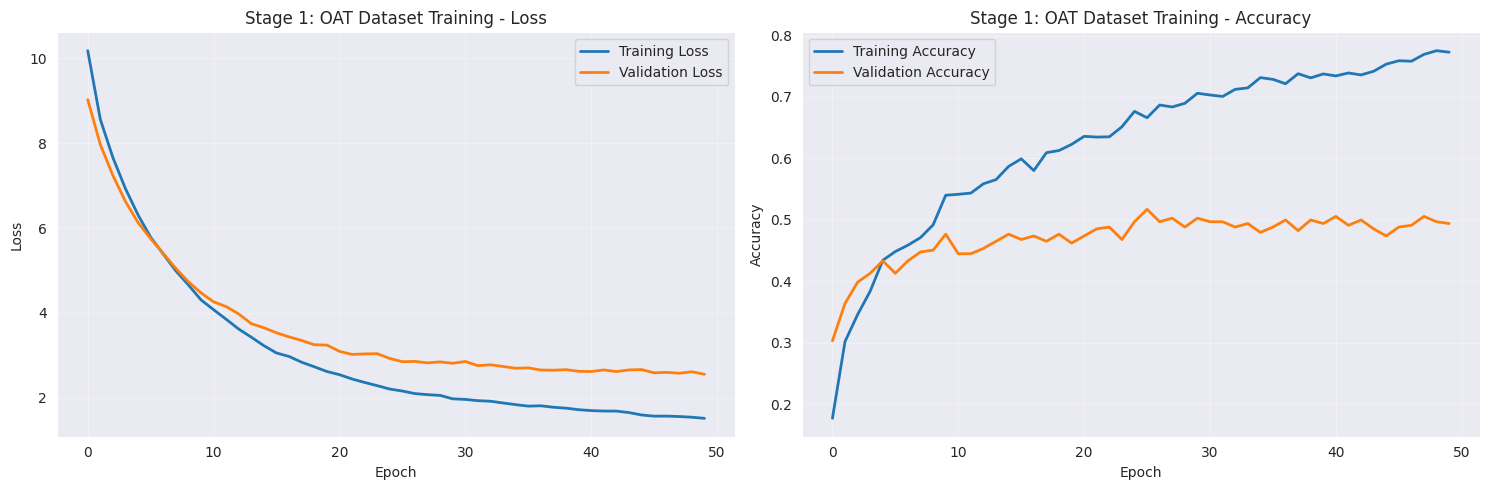


Stage 1: OAT Dataset Training Final Metrics:
Training Accuracy: 0.7729
Validation Accuracy: 0.4942
Training Loss: 1.5168
Validation Loss: 2.5551


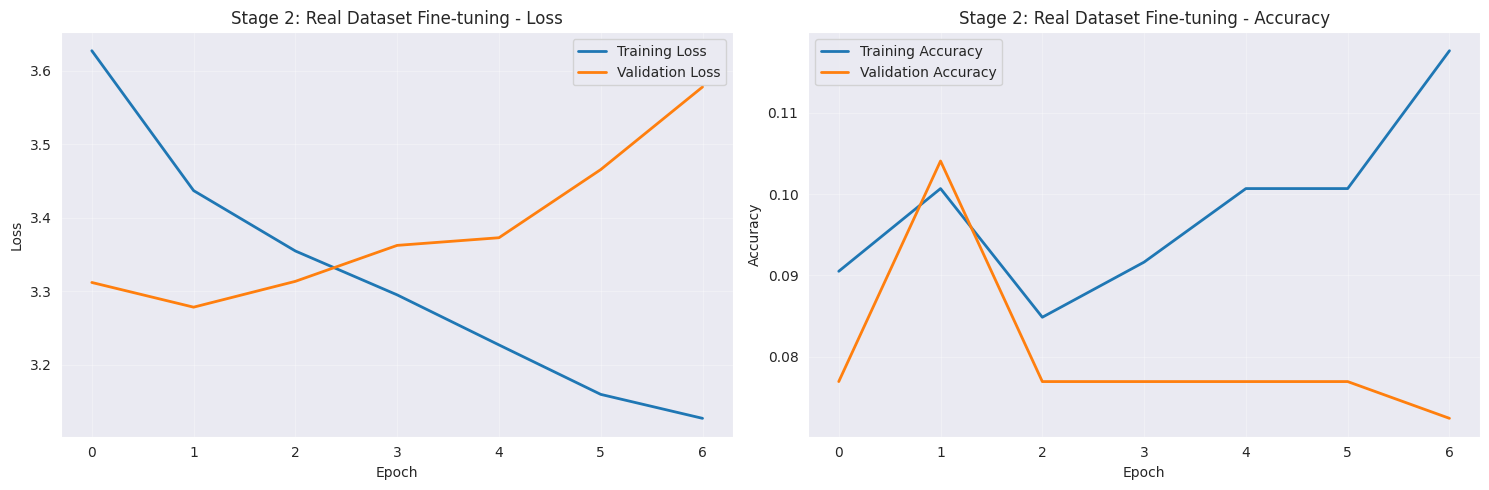


Stage 2: Real Dataset Fine-tuning Final Metrics:
Training Accuracy: 0.1176
Validation Accuracy: 0.0724
Training Loss: 3.1269
Validation Loss: 3.5779


In [35]:
# Plot training histories
def plot_training_history(history, title, stage_num):
    fig, (ax1, ax2) = plt.subplots(1, 2, figsize=(15, 5))
    
    # Loss plot
    ax1.plot(history.history['loss'], label='Training Loss', linewidth=2)
    ax1.plot(history.history['val_loss'], label='Validation Loss', linewidth=2)
    ax1.set_title(f'{title} - Loss')
    ax1.set_xlabel('Epoch')
    ax1.set_ylabel('Loss')
    ax1.legend()
    ax1.grid(True, alpha=0.3)
    
    # Accuracy plot
    ax2.plot(history.history['accuracy'], label='Training Accuracy', linewidth=2)
    ax2.plot(history.history['val_accuracy'], label='Validation Accuracy', linewidth=2)
    ax2.set_title(f'{title} - Accuracy')
    ax2.set_xlabel('Epoch')
    ax2.set_ylabel('Accuracy')
    ax2.legend()
    ax2.grid(True, alpha=0.3)
    
    plt.tight_layout()
    plt.show()
    
    # Print final metrics
    final_train_acc = history.history['accuracy'][-1]
    final_val_acc = history.history['val_accuracy'][-1]
    final_train_loss = history.history['loss'][-1]
    final_val_loss = history.history['val_loss'][-1]
    
    print(f"\n{title} Final Metrics:")
    print(f"Training Accuracy: {final_train_acc:.4f}")
    print(f"Validation Accuracy: {final_val_acc:.4f}")
    print(f"Training Loss: {final_train_loss:.4f}")
    print(f"Validation Loss: {final_val_loss:.4f}")
    
# Plot both training histories
plot_training_history(stage1_history, "Stage 1: OAT Dataset Training", 1)
plot_training_history(stage2_history, "Stage 2: Real Dataset Fine-tuning", 2)

In [36]:
# Generate predictions for confusion matrix (Stage 2)
y_true = []
y_pred = []

for batch_images, batch_labels in real_val_ds:
    predictions = stage2_model.predict(batch_images, verbose=0)
    predicted_classes = np.argmax(predictions, axis=1)
    
    y_true.extend(batch_labels.numpy())
    y_pred.extend(predicted_classes)

y_true = np.array(y_true)
y_pred = np.array(y_pred)

2025-07-03 14:39:31.141068: I tensorflow/core/framework/local_rendezvous.cc:405] Local rendezvous is aborting with status: OUT_OF_RANGE: End of sequence


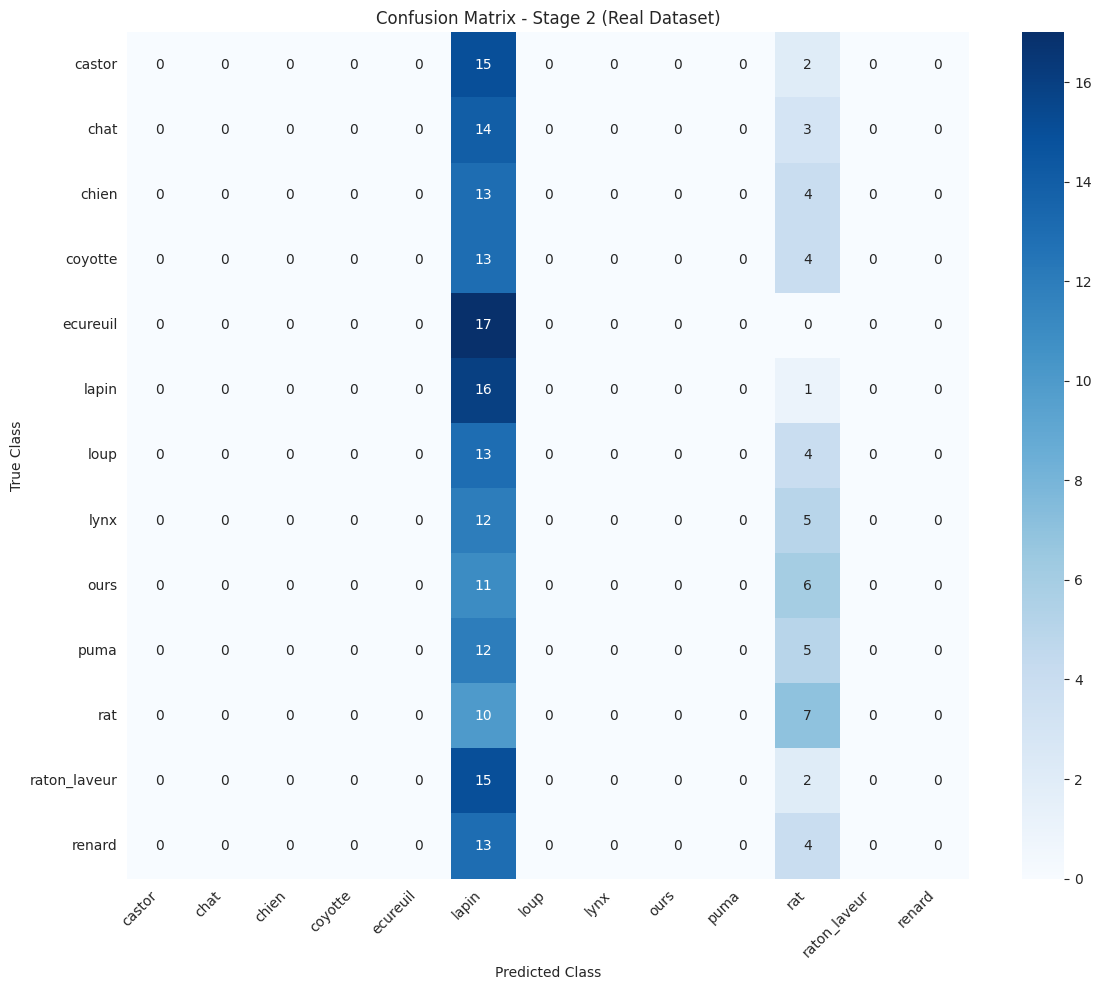

In [37]:
# Plot confusion matrix
cm = confusion_matrix(y_true, y_pred)
plt.figure(figsize=(12, 10))
sns.heatmap(cm, annot=True, fmt='d', cmap='Blues', 
            xticklabels=real_class_names, 
            yticklabels=real_class_names)
plt.title('Confusion Matrix - Stage 2 (Real Dataset)')
plt.xlabel('Predicted Class')
plt.ylabel('True Class')
plt.xticks(rotation=45, ha='right')
plt.yticks(rotation=0)
plt.tight_layout()
plt.show()

In [38]:
# Classification report
print("\nClassification Report - Stage 2 (Real Dataset):")
print("=" * 60)
report = classification_report(y_true, y_pred, target_names=real_class_names, digits=4)
print(report)


Classification Report - Stage 2 (Real Dataset):
              precision    recall  f1-score   support

      castor     0.0000    0.0000    0.0000        17
        chat     0.0000    0.0000    0.0000        17
       chien     0.0000    0.0000    0.0000        17
     coyotte     0.0000    0.0000    0.0000        17
    ecureuil     0.0000    0.0000    0.0000        17
       lapin     0.0920    0.9412    0.1675        17
        loup     0.0000    0.0000    0.0000        17
        lynx     0.0000    0.0000    0.0000        17
        ours     0.0000    0.0000    0.0000        17
        puma     0.0000    0.0000    0.0000        17
         rat     0.1489    0.4118    0.2188        17
raton_laveur     0.0000    0.0000    0.0000        17
      renard     0.0000    0.0000    0.0000        17

    accuracy                         0.1041       221
   macro avg     0.0185    0.1041    0.0297       221
weighted avg     0.0185    0.1041    0.0297       221



/home/hugo/miniconda3/envs/tf/lib/python3.12/site-packages/sklearn/metrics/_classification.py:1706: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", result.shape[0])
/home/hugo/miniconda3/envs/tf/lib/python3.12/site-packages/sklearn/metrics/_classification.py:1706: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", result.shape[0])
/home/hugo/miniconda3/envs/tf/lib/python3.12/site-packages/sklearn/metrics/_classification.py:1706: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is

In [39]:
# Per-class accuracy analysis
from sklearn.metrics import accuracy_score
import pandas as pd

# Calculate per-class accuracy
per_class_accuracy = []
for i, class_name in enumerate(real_class_names):
    class_mask = y_true == i
    if np.sum(class_mask) > 0:
        class_acc = accuracy_score(y_true[class_mask], y_pred[class_mask])
        per_class_accuracy.append(class_acc)
    else:
        per_class_accuracy.append(0.0)

# Create DataFrame for better visualization
results_df = pd.DataFrame({
    'Class': real_class_names,
    'Accuracy': per_class_accuracy,
    'Support': [np.sum(y_true == i) for i in range(len(real_class_names))]
})

results_df = results_df.sort_values('Accuracy', ascending=False)
print("\nPer-Class Performance:")
print("=" * 40)
print(results_df.to_string(index=False, float_format='%.4f'))

# Overall metrics
overall_accuracy = accuracy_score(y_true, y_pred)
print(f"\nOverall Accuracy: {overall_accuracy:.4f}")
print(f"Mean Per-Class Accuracy: {np.mean(per_class_accuracy):.4f}")


Per-Class Performance:
       Class  Accuracy  Support
       lapin    0.9412       17
         rat    0.4118       17
       chien    0.0000       17
        chat    0.0000       17
      castor    0.0000       17
    ecureuil    0.0000       17
     coyotte    0.0000       17
        lynx    0.0000       17
        loup    0.0000       17
        ours    0.0000       17
        puma    0.0000       17
raton_laveur    0.0000       17
      renard    0.0000       17

Overall Accuracy: 0.1041
Mean Per-Class Accuracy: 0.1041


## Model Summary and Results

In [40]:
print("MOBILENET TWO-STAGE TRAINING PIPELINE - FINAL RESULTS")
print("="*80)

print("\nCONFIGURATION:")
print(f"- Architecture: MobileNetV3Small + Custom Classification Head")
print(f"- Stage 1 Dataset: OAT ({len(oat_class_names)} classes)")
print(f"- Stage 2 Dataset: Real ({len(real_class_names)} classes)")

print("\nSTAGE 1 RESULTS (OAT Dataset):")
print(f"- Test Accuracy: {stage1_test_accuracy:.4f}")
print(f"- Test Loss: {stage1_test_loss:.4f}")
print(f"- Epochs Trained: {len(stage1_history.history['loss'])}")

print("\nSTAGE 2 RESULTS (Real Dataset):")
print(f"- Validation Accuracy: {stage2_val_accuracy:.4f}")
print(f"- Validation Loss: {stage2_val_loss:.4f}")
print(f"- Epochs Trained: {len(stage2_history.history['loss'])}")
print(f"- Overall Test Accuracy: {overall_accuracy:.4f}")

print("\nSAVED MODELS:")
print("- mobilenet_oat_stage1.keras (Stage 1: OAT training)")
print("- mobilenet_real_stage2.keras (Stage 2: Real fine-tuning)")

MOBILENET TWO-STAGE TRAINING PIPELINE - FINAL RESULTS

CONFIGURATION:
- Architecture: MobileNetV3Small + Custom Classification Head
- Stage 1 Dataset: OAT (18 classes)
- Stage 2 Dataset: Real (13 classes)

STAGE 1 RESULTS (OAT Dataset):
- Test Accuracy: 0.5146
- Test Loss: 2.4543
- Epochs Trained: 50

STAGE 2 RESULTS (Real Dataset):
- Validation Accuracy: 0.1041
- Validation Loss: 3.2782
- Epochs Trained: 7
- Overall Test Accuracy: 0.1041

SAVED MODELS:
- mobilenet_oat_stage1.keras (Stage 1: OAT training)
- mobilenet_real_stage2.keras (Stage 2: Real fine-tuning)
